# SPIB Workflow Tutorial

This notebook demonstrates how to use `geom2vec` to:

- Train a VAMPNet on precomputed geom2vec embeddings (as in `5_vamp_workflow.ipynb`).
- Cluster the resulting collective variables (CVs) with K-means to obtain initial discrete labels.
- Construct a SPIB dataset using `geom2vec.data.Preprocessing.create_spib_dataset`.
- Train a `SPIBModel` to learn a low-dimensional information bottleneck representation.


In [1]:
from pathlib import Path

import numpy as np
import torch
from sklearn.cluster import MiniBatchKMeans

from geom2vec.data import Preprocessing
from geom2vec.models.downstream import Lobe, VAMPWorkflow, SPIBModel
from geom2vec.models.downstream.vamp.vampnet import VAMPNetConfig
from geom2vec.models.downstream.vamp.workflow import build_trajectories_from_embedding_dir


/project/dinner/zpengmei/conda_envs/openmm/lib/python3.12/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /project/dinner/zpengmei/conda_envs/openmm/lib/python3.12/site-packages/libpyg.so)
  import torch_geometric.typing
/project/dinner/zpengmei/conda_envs/openmm/lib/python3.12/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /project/dinner/zpengmei/conda_envs/openmm/lib/python3.12/site-packages/libpyg.so)
  import torch_geometric.typing


## Load Precomputed Embeddings

Point `embedding_dir` to the folder produced by the inference notebook (e.g.
`4_infer_mdanalysis.ipynb`). Each `.pt` file should contain a tensor of shape
`(num_frames, num_tokens, 4, hidden_channels)`


In [2]:
embedding_dir = Path("/project/dinner/zpengmei/geom2vec_runs/trpcage_infer/")
lag_time = 10
train_fraction = 0.8  # fraction of data used for training when multiple trajectories exist

trajectories, graph_trajectories, ca_trajectories = build_trajectories_from_embedding_dir(embedding_dir)
print(f"Loaded {len(graph_trajectories)} trajectories with shapes: {[traj.shape for traj in graph_trajectories]}")

/project/dinner/zpengmei/apps/geom2vec/src/geom2vec/models/downstream/vamp/workflow.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_trajectories = [torch.load(pa

Loaded 105 trajectories with shapes: [torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), torch.Size([1000, 20, 4, 128]), to

## Configure and Train VAMPNet

We first set up a `Lobe` and a `VAMPWorkflow` (as in `5_vamp_workflow.ipynb`) to learn slow CVs from the embeddings.


In [3]:
from copy import deepcopy
hidden_channels = graph_trajectories[0].shape[-1]
num_tokens = graph_trajectories[0].shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lag_time = 10

lobe = Lobe(
    input_channels=hidden_channels,
    hidden_channels=64,
    output_channels=5,
    num_mlp_layers=2,
    num_tokens=num_tokens,
    num_mixer_layers=4,
    equi_rep=True,
    merger=False,
    merger_window=2,
    equi_backend='torch',
).cuda()

lobe = lobe.to(device)
lobe_tlag = deepcopy(lobe)



config = VAMPNetConfig(
    device='cuda',  # change to 'cuda' once FlashAttention kernels are available
    train_patience=50,
    valid_patience=50,
    train_valid_interval=25,
    learning_rate=1e-4,
    score_method='vamp-2',
    optimizer='AdamAtan2'
)

workflow = VAMPWorkflow(
    lobe=lobe.to(device),
    lobe_lagged=lobe_tlag.to(device),
    trajectories=trajectories,
    lag_time=lag_time,
    config=config,
    train_fraction=train_fraction,
    batch_size=2000,
    seed=0,
    concat_trajectories=True,
)
workflow



In [4]:
vamp = workflow.fit(n_epochs=10, progress=lambda iterable, **_: iterable)
print("Training batches:", len(workflow.train_loader))


best val: -inf: 0it [00:00, ?it/s]

Training batches: 42


In [5]:
vamp.validation_scores

array([1.49278128, 1.94992805, 2.21790481, 2.45785904, 2.87942243,
       3.07526684, 3.31953812, 3.45397067, 3.4995985 , 3.55221629,
       3.65807676, 3.6825192 , 3.7174809 , 3.85832024, 3.85303879,
       3.91071606])

In [6]:
vamp.training_scores

array([1.07897532, 1.07103801, 1.13985574, 1.13278663, 1.14982724,
       1.22371233, 1.20376945, 1.24255347, 1.22928786, 1.30972195,
       1.33961976, 1.34212649, 1.3461895 , 1.34999764, 1.4463253 ,
       1.46298981, 1.46859884, 1.47495532, 1.53007245, 1.47178805,
       1.53617334, 1.6168251 , 1.53764784, 1.63650632, 1.57685661,
       1.61994576, 1.66997969, 1.70068538, 1.64716291, 1.68930817,
       1.74432898, 1.87280822, 1.87243319, 1.88899922, 1.85592723,
       1.98734629, 1.97246122, 2.09422946, 2.04896641, 1.96241379,
       1.92417407, 2.02305508, 2.07206821, 2.16232872, 2.17249298,
       2.2233119 , 2.16791248, 2.14413452, 2.21276855, 2.22746658,
       2.17256498, 2.22511292, 2.28279424, 2.3409605 , 2.27897549,
       2.35945702, 2.34015942, 2.35650349, 2.33491468, 2.41730595,
       2.37316179, 2.38268852, 2.43003798, 2.38473511, 2.45448542,
       2.40973496, 2.42321634, 2.46578765, 2.44606113, 2.44568825,
       2.50192928, 2.4834342 , 2.47836065, 2.53651547, 2.38857

## Compute CVs and Initial Discrete Labels

We transform the original trajectories through the trained VAMPNet to obtain CV trajectories,
then apply `MiniBatchKMeans` to define initial discrete state labels for SPIB.


In [7]:
# Obtain CVs for all trajectories using the trained VAMPNet
cvs = workflow.transform(trajectories, instantaneous=True, return_cv=True, batch_size=512)

# Ensure we always work with a list of arrays
if isinstance(cvs, np.ndarray):
    cvs_list = [cvs]
else:
    cvs_list = list(cvs)

# Concatenate CVs across all trajectories for clustering
cvs_concat = np.concatenate(cvs_list, axis=0)
print("Total CV frames:", cvs_concat.shape[0], "dim:", cvs_concat.shape[1])

n_clusters = 200  # number of discrete states for SPIB
kmeans = MiniBatchKMeans(n_clusters=n_clusters, n_init=10, random_state=0, batch_size=4096)
cluster_labels = kmeans.fit_predict(cvs_concat)

# Split cluster labels back into trajectory-wise arrays
labels_per_traj = []
offset = 0
for traj_cvs in cvs_list:
    length = traj_cvs.shape[0]
    labels = cluster_labels[offset:offset + length]
    labels_per_traj.append(np.asarray(labels, dtype=np.int64))
    offset += length

print("Created labels for", len(labels_per_traj), "trajectories.")


Total CV frames: 104400 dim: 5
Created labels for 105 trajectories.


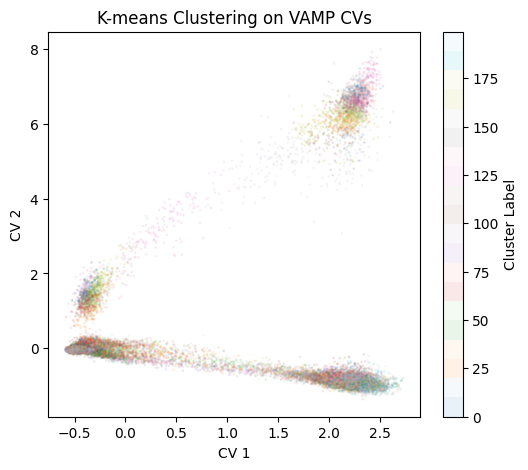

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(cvs_concat[:,0], cvs_concat[:,1], s=1, alpha=0.1, c=cluster_labels, cmap='tab20')
plt.xlabel("CV 1")
plt.ylabel("CV 2")
plt.title("K-means Clustering on VAMP CVs")
plt.colorbar(label="Cluster Label")
plt.show()

## Build SPIB Datasets

We now flatten the original geom2vec embeddings per frame, pair them with the K-means labels,
and use `Preprocessing.create_spib_dataset` to construct train and validation datasets for `SPIBModel`.


In [25]:
preprocess = Preprocessing(dtype=torch.float32, backend="none")
lag_time = 10

train_dataset, test_dataset = preprocess.create_spib_train_test_datasets(
    data_list=trajectories,
    label_list=labels_per_traj,
    train_fraction=train_fraction,
    lag_time=lag_time,
    output_dim=n_clusters,
)


## Train the SPIB Model

We reuse the `Lobe` architecture as an encoder: flattened embeddings are reshaped back to
token/scalar/vector form and passed through a `Lobe` head to produce the features consumed by `SPIBModel`.


In [26]:
hidden_dim_spib = 128
lag_time = 10
# Lobe used as SPIB encoder (separate from the VAMP lobe)
spib_lobe = Lobe(
    input_channels=hidden_channels,
    hidden_channels=hidden_channels,
    output_channels=hidden_dim_spib,
    num_mlp_layers=2,
    num_tokens=num_tokens,
    equi_rep=True,
    merger=False,
    merger_window=2,
    equi_backend="torch",
).to(device)

spib = SPIBModel.from_lobe(
    lobe=spib_lobe,
    num_tokens=num_tokens,
    hidden_channels=hidden_channels,
    output_dim=n_clusters,
    lag_time=lag_time,
    device=device,
)

_ = spib.fit(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    batch_size=2048,
    tolerance=0.001,
    patience=5,
    refinements=5,
    max_epochs_per_refinement=20,
)


Epoch 1:	Time 8.07 s
Loss (train): 5.133549	KL loss (train): 0.332633
Reconstruction loss (train): 5.133215
Loss (test): 4.773108	KL loss (test): 1.525112
Reconstruction loss (test): 4.771583
State population:
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9996364e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.000000

## Transform Data with SPIB

Finally, we use the trained SPIB model to obtain discrete labels and latent variables,
which can be further analyzed or visualized.


In [27]:
labels, all_prediction, z_mean, z_logvar = spib.transform(
    trajectories,  # the list of dicts from build_trajectories_from_embedding_dir
    batch_size=2048,
    to_numpy=True,
)

print("SPIB latent mean shape:", z_mean.shape)
print("Unique SPIB labels:", np.unique(labels))


SPIB latent mean shape: (104400, 2)
Unique SPIB labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]


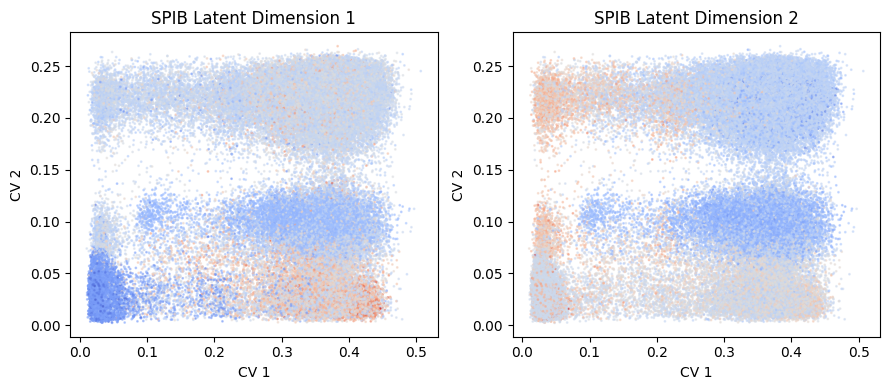

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cv1 = np.load('/beagle3/dinner/chatipat/projects/geom2vec-examples/data/trpcage/helix1_rmsd.npy')[::10]
cv2 = np.load('/beagle3/dinner/chatipat/projects/geom2vec-examples/data/trpcage/helix2_rmsd.npy')[::10]

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].scatter(cv1, cv2, s=1, alpha=0.5, c=z_mean[:,0], cmap='coolwarm')
axs[0].set_xlabel('CV 1')
axs[0].set_ylabel('CV 2')
axs[0].set_title('SPIB Latent Dimension 1')


axs[1].scatter(cv1, cv2, s=1, alpha=0.5, c=z_mean[:,1], cmap='coolwarm')
axs[1].set_xlabel('CV 1')
axs[1].set_ylabel('CV 2')
axs[1].set_title('SPIB Latent Dimension 2')
plt.tight_layout()
plt.show()


In [29]:
import mdtraj as md
import py3Dmol
import os

topology_file = (
    "/project/dinner/anton_data/TRP_cage/trpcage.pdb"
)
trajectory_folder = (
    "/project/dinner/anton_data/TRP_cage/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein"
)

# find all .dcd files in the trajectory folder
dcd_files = sorted(
    [
        os.path.join(trajectory_folder, f)
        for f in os.listdir(trajectory_folder)
        if f.endswith(".dcd")
    ]
)

# load the trajectory using mdtraj
traj = md.load(dcd_files, top=topology_file,stride=10)
traj

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


<mdtraj.Trajectory with 104400 frames, 272 atoms, 20 residues, and unitcells at 0x7f89dd80fdd0>

percentage: [ 2.27203065  3.12164751  0.59578544  8.25383142 10.41858238  1.09770115
  3.51628352  0.21360153  6.68773946 14.78256705 47.15038314  1.88984674]


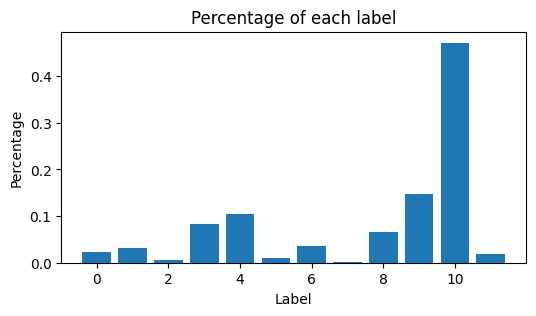

Ranking of the population of each cluster:
Cluster 10: 47.15%
Cluster 9: 14.78%
Cluster 4: 10.42%
Cluster 3: 8.25%
Cluster 8: 6.69%
Cluster 6: 3.52%
Cluster 1: 3.12%
Cluster 0: 2.27%
Cluster 11: 1.89%
Cluster 5: 1.10%
Cluster 2: 0.60%
Cluster 7: 0.21%


In [30]:
# count the percentage of each label
unique, counts = np.unique(labels,return_counts=True)
percentage = counts / len(labels)
print('percentage:', percentage * 100)
# plot the percentage of each label in a ci
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.bar(unique,percentage)
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.title('Percentage of each label')
plt.show()

# rank the population of each cluster
print('Ranking of the population of each cluster:')
rank = np.argsort(percentage)[::-1]
for i in range(len(rank)):
    print(f'Cluster {rank[i]}: {percentage[rank[i]]*100:.2f}%')

In [31]:
def get_traj_frame_index(index,traj_lengths):
    '''
    Get the trajectory index and frame index from the global index

    Parameters
    ----------
    index : int
        The global index of the frame
    traj_lengths : list
        The lengths of trajectories
    '''

    traj_index = 0
    frame_index = index
    for i in range(len(traj_lengths)):
        if frame_index < traj_lengths[i]:
            traj_index = i
            break
        else:
            frame_index -= traj_lengths[i]
    
    return traj_index, frame_index

traj_lengths = [len(traj['ca_coords']) for traj in trajectories]

traj_index, frame_index = get_traj_frame_index(6180, traj_lengths)
print(traj_index, frame_index)

6 180


In [ ]:
# save cluster 0 structures to disk for visualization
import mdtraj as md
import os


CLUSTER=3
cluster_indices = np.where(labels == CLUSTER)[0]
top_file = "/project/dinner/anton_data/TRP_cage/trpcage.pdb"



if not os.path.exists(f'/project/dinner/zpengmei/apps/geom2vec/examples/trpcage/clusters/{CLUSTER}'):
    os.makedirs(f'/project/dinner/zpengmei/apps/geom2vec/examples/trpcage/clusters/{CLUSTER}')

# shuffle the cluster0 indices
np.random.shuffle(cluster_indices)

ref_traj = md.load(dcd_files[0], top=top_file, stride=10)
for i in range(0,20):
    traj_index, frame_index = get_traj_frame_index(cluster_indices[i], traj_lengths)
    traj = md.load(dcd_files[traj_index], top=top_file, stride=10)
    frame = traj[frame_index]
    frame = frame.superpose(ref_traj[0])
    frame.save_pdb(f'/project/dinner/zpengmei/apps/geom2vec/examples/trpcage/clusters/{CLUSTER}/frame_{i}.pdb')

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


In [70]:
import py3Dmol

view = py3Dmol.view(width=400, height=400)

# Add the first model
view.addModel(open(f'/project/dinner/zpengmei/apps/geom2vec/examples/trpcage/clusters/{CLUSTER}/frame_0.pdb').read(), 'pdb')
view.setStyle({'model': 0}, {'cartoon': {'color': 'spectrum', 'opacity': 1}})

for i in range(1, 20):
    view.addModel(open(f'/project/dinner/zpengmei/apps/geom2vec/examples/trpcage/clusters/{CLUSTER}/frame_{i}.pdb').read(), 'pdb')

view.setStyle({'model': list(range(1, 20))}, {'cartoon': {'color': 'spectrum', 'opacity': 0.6, 'thickness': 0.2}})
view.zoomTo()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.